# Mario Kart 64 World Records

## About

This page showcases the work of [Cedric Sherer](https://www.cedricscherer.com), built for the [TidyTuesday](https://github.com/rfordatascience/tidytuesday) initiative. You can find the original code on his github repository [here](https://github.com/z3tt/TidyTuesday/blob/master/R/2021_22_MarioKart.Rmd). Thanks to him for accepting sharinig his work here! 🙏🙏

## Load libraries

In [1]:
import palettable

import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Load and prepare the dataset

Here we read data from the original source bla bla... and explore the first lines.

In [3]:
df_records = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-05-25/records.csv')
df_records.head()

,track,type,shortcut,player,system_played,date,time_period,time,record_duration
0,Luigi Raceway,Three Lap,No,Salam,NTSC,1997-02-15,2M 12.99S,132.99,1
1,Luigi Raceway,Three Lap,No,Booth,NTSC,1997-02-16,2M 9.99S,129.99,0
2,Luigi Raceway,Three Lap,No,Salam,NTSC,1997-02-16,2M 8.99S,128.99,12
3,Luigi Raceway,Three Lap,No,Salam,NTSC,1997-02-28,2M 6.99S,126.99,7
4,Luigi Raceway,Three Lap,No,Gregg G,NTSC,1997-03-07,2M 4.51S,124.51,54


Today's visualization is based on records for complete races only. Our first step is to create a `pandas.DataFrame` called `df_rank` that keeps current world records for every track.

In [4]:
# Any preferred approach here?
df_rank = df_records.query("type == 'Three Lap'")
df_rank = (
    df_rank.loc[df_rank.groupby("track")["time"].idxmin()]
     .sort_values("time", ascending=False)
     .assign(track = lambda df: pd.Categorical(df['track'], ordered=True, categories=df["track"]))
)

In [5]:
# Keep records where type is Three Lap
df_rank = df_records.query("type == 'Three Lap'")

# Keep records with the minimum time for each track
df_rank = df_rank.loc[df_rank.groupby("track")["time"].idxmin()]

# Sort by descending time
df_rank = df_rank.sort_values("time", ascending=False)

# Make "track" ordered categorical with order given by descending times
# This categorical type will be used to sort the tracks in the plot.
df_rank["track"] = pd.Categorical(df_rank["track"], ordered=True,  categories=df_rank["track"])

Then we have `df_records_three` which holds all the records, no matter they were beaten or not. It is used to derive other data frames that used in our chart.

In [6]:
# We call '.reset_index()' to avoid SettingWithCopyWarning
df_records_three = df_records.query("type == 'Three Lap'").reset_index() 
df_records_three["year"] = pd.DatetimeIndex(df_records_three["date"]).year

`df_connect` is the first data frame we derive. This one is used to add a dotted line that connects record times with and without shortcuts and will serve as a reference for their difference.

In [7]:
# First of all, for each track and shortcut, obtain the minimum and maximum
# value of time. These represent the most recent and first records, respectively.
df_connect = df_records_three.groupby(["track", "shortcut"]).agg(
    no = ("time", min),
    yes = ("time", max)
).reset_index()

# Next put it into long format.
# Each row indicates the track, whether shortcuts were used, 
# if it's the current record, and the time achieved.
df_connect = pd.melt(
    df_connect,
    id_vars=["track", "shortcut"],
    value_vars=["no", "yes"],
    var_name="record",
    value_name="time"
)

# The dotted line goes from the first record without shortcut (the slowest)
# to the most recent record with shortcut (the fastest)
df_connect = df_connect.query(
    "(shortcut == 'No' and record == 'no') or (shortcut == 'Yes' and record == 'yes')"
)

# Finally it is put in wide format, where there's only one row per track.
df_connect = df_connect.pivot_table(index="track", columns="record", values="time").reset_index()

We also have `df_longdist` and `df_shortcut`. Note each data frame consists of five columns: `track`, `year`, `max`, `min`, and `diff`. `year` refers to the year where the current record was achieved, `max` is the completetion time for the first record and `min` is the time for the current record. `diff` is simply the difference between `max` and `min`, i.e. a measurement of how much the first record was improved. `df_shortcut` and `df_longdist` refer to records with and without shortcuts, respectively.

In [8]:
# Long dist refers to records without shortcut
df_longdist = df_records_three.query("shortcut == 'No'")

# Only keep observations referring to either the first or the most recent record, 
# by track.
grouped = df_longdist.groupby("track")
df_longdist = df_longdist.loc[pd.concat([grouped["time"].idxmax(), grouped["time"].idxmin()])]

# Create a 'group' variable that indicates whether the record
# refers to the first record, the one with maximum time,
# or to the most recent record, the one with minimum time.
df_longdist.loc[grouped["time"].idxmax(), "group"] = "max"
df_longdist.loc[grouped["time"].idxmin(), "group"] = "min"

# 'year' records the year of the most recent record
df_longdist["year"] = df_longdist.groupby("track")['year'].transform(max)

# Put the data in wide format, i.e., one observation per track.
df_longdist = df_longdist.pivot_table(index=["track", "year"], columns="group", values="time").reset_index()
df_longdist["diff"] = df_longdist["max"] - df_longdist["min"]

In [9]:
# Same process than above, but using records where shortcut is "Yes"
df_shortcut = df_records_three.query("shortcut == 'Yes'")
grouped = df_shortcut.groupby("track")
df_shortcut = df_shortcut.loc[pd.concat([grouped["time"].idxmax(), grouped["time"].idxmin()])]
df_shortcut.loc[grouped["time"].idxmax(), "group"] = "max"
df_shortcut.loc[grouped["time"].idxmin(), "group"] = "min"

df_shortcut["year"] = df_shortcut.groupby("track")['year'].transform(max)
df_shortcut = df_shortcut.pivot_table(index=["track", "year"], columns="group", values="time").reset_index()
df_shortcut["diff"] = df_shortcut["max"] - df_shortcut["min"]

All the datasets are sorted according to the order of `"track"` in `df_rank`. To do so, we first set the type of the `"track"` variable equal to the categorical type in `df_rank`, and then sort according to its levels.

In [10]:
tracks_sorted = df_rank["track"].dtype.categories.tolist()

In [11]:
# Sort df_connect
df_connect["track"] = df_connect["track"].astype("category")
df_connect["track"].cat.set_categories(tracks_sorted, inplace=True)
df_connect = df_connect.sort_values("track")

# Sort df_longdist
df_longdist["track"] = df_longdist["track"].astype("category")
df_longdist["track"].cat.set_categories(tracks_sorted, inplace=True)
df_longdist = df_longdist.sort_values("track")

# Sort df_shortcut
df_shortcut["track"] = df_shortcut["track"].astype("category")
df_shortcut["track"].cat.set_categories(tracks_sorted, inplace=True)
df_shortcut = df_shortcut.sort_values("track")

This highly customized plot demands a lot of code. It is a good practice to define the colors at the very beginning so we can refer to them by name.

In [12]:
# Names for the grey colors are taken from R
GREY94 = "#f0f0f0"
GREY65 = "#a6a6a6"
GREY50 = "#7f7f7f"
GREY40 = "#666666"
LIGHT_BLUE = "#b4d1d2"
DARK_BLUE = "#242c3c"
BLUE = "#4a5a7b"
WHITE = "#FFFCFC" # technically not pure white

Today we make use of the `palettable` library to make use of the `RedOr` palette, which is the one used in the original plot. We will also make use of the `matplotlib.colors.Normalize` class to normalize values into the (0, 1) interval before we pass it to our `colormap` function and `matplotlib.colors.LinearSegmentedColormap` to create a custom colormap for blue colors.

In [13]:
# 'colormap' is now a function
colormap_orange = palettable.cartocolors.sequential.RedOr_5.mpl_colormap

# And we also create a new colormap using 
colormap_blue = mc.LinearSegmentedColormap.from_list("blue", [LIGHT_BLUE, DARK_BLUE], N=256)

In [14]:
import matplotlib.patheffects as pe

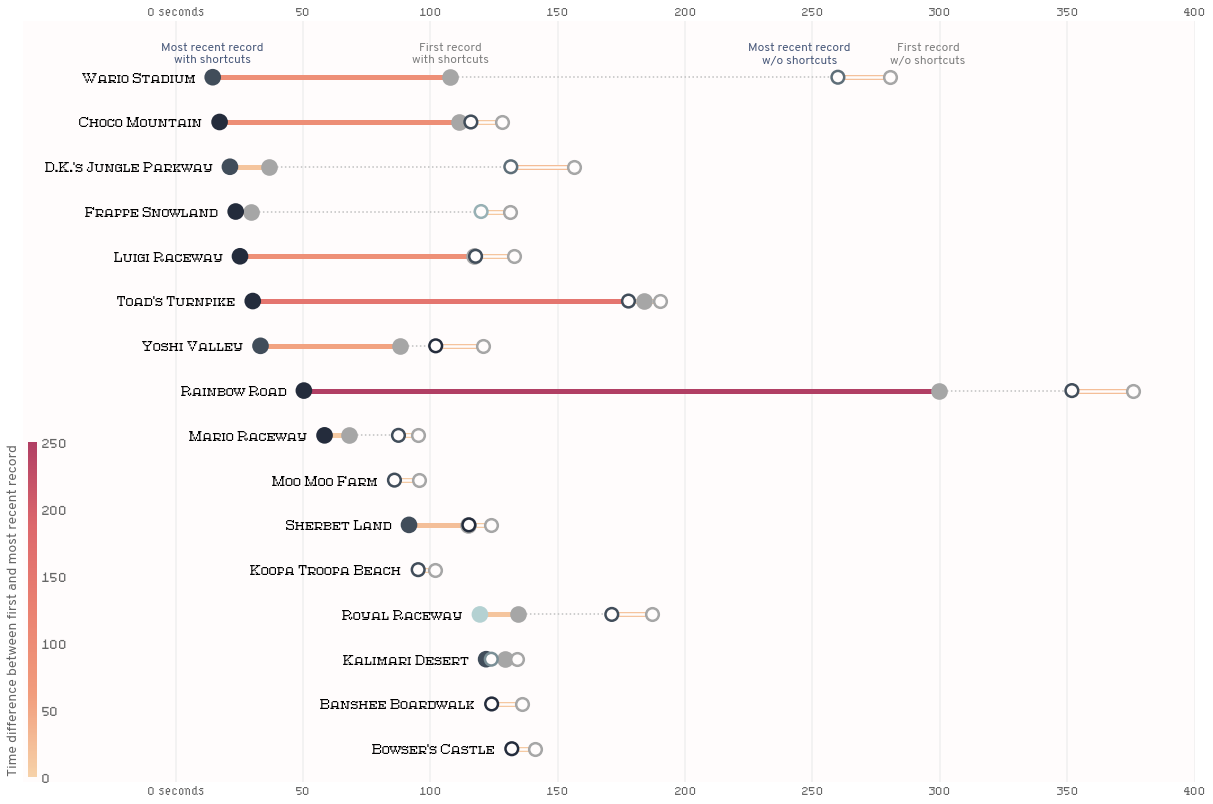

In [15]:
fig, ax = plt.subplots(figsize = (21, 14))

# Add segments ---------------------------------------------------

# Dotted line connection shortcut yes/no
ax.hlines(y="track", xmin="yes", xmax="no", color="#bfbfbf", ls=":", data=df_connect)

# Segment when shortcut==yes
# First time we use the colormap and the normalization
norm = mc.Normalize(vmin=0, vmax=250)
color = colormap_orange(norm(df_shortcut["diff"].values))
ax.hlines(y="track", xmin="min", xmax="max", color=color, lw=5, data=df_shortcut)

# Segment when shortcut==no. Note we are overlapping lineranges
# We use the same normalization scale.
color = colormap_orange(norm(df_longdist["diff"].values))
ax.hlines(y="track", xmin="min", xmax="max", color=color, lw=5, data=df_longdist)
ax.hlines(y="track", xmin="min", xmax="max", color=WHITE, lw=2.5, data=df_longdist)


# Add dots -------------------------------------------------------
## Dots when shortcut==yes – first record
# zorder is added to ensure dots are on top
ax.scatter(x="max", y="track", s=200, color=GREY65, edgecolors=GREY65, lw=2.5, zorder=2, data=df_shortcut)

## Dots when shortcut==yes – latest record
# This time we normalize using the range of years in the data, and use blue colormap
norm = mc.Normalize(df_shortcut["year"].min(), df_shortcut["year"].max())
color = colormap_blue(norm(df_shortcut["year"].values))
ax.scatter(x="min", y="track", s=200, color=color, edgecolors=color, lw=2.5, zorder=2, data=df_shortcut)

## Dots shortcut==no – first record
color = colormap_blue(norm(df_longdist["year"].values))
ax.scatter(x="min", y="track", s=160, color=WHITE, edgecolors=color, lw=2.5, zorder=2, data=df_longdist)

## Dots shortcut==no – latest record
ax.scatter(x="max", y="track", s=160, color=WHITE, edgecolors=GREY65, lw=2.5, zorder=2, data=df_longdist)



## labels tracks
# Annotations for tracks in df_shortcut
for row in range(df_shortcut.shape[0]):
     ax.text(
        df_shortcut["min"][row] - 7, 
        df_shortcut["track"][row], 
        df_shortcut["track"][row], 
        ha="right", 
        va="center",
        size=18, 
        color="black",
        fontname="Atlantis"
    )

# Annotations for df_longdist, not in df_shortcut
for row in range(df_longdist.shape[0]):
    if df_longdist["track"][row] not in df_shortcut["track"].values:
        ax.text(
            df_longdist["min"][row] - 7, 
            df_longdist["track"][row], 
            df_longdist["track"][row], 
            ha="right", 
            va="center",
            size=18,
            color="black",
            fontname="Atlantis",
        )

## labels dots shortcut yes
df_shortcut_wario = df_shortcut.query("track == 'Wario Stadium'")
ax.text(
    df_shortcut_wario["min"], 
    df_shortcut_wario["track"], 
    "Most recent record\nwith shortcuts\n", 
    color=BLUE,
    ma="center",
    va="bottom",
    ha="center",
    size=12,
    fontname="Overpass"
)
ax.text(
    df_shortcut_wario["max"], 
    df_shortcut_wario["track"], 
    "First record\nwith shortcuts\n", 
    color=GREY50,
    ma="center",
    va="bottom",
    ha="center",
    size=12,
    fontname="Overpass"
)

## labels dots shortcut no
df_longdist_wario = df_longdist.query("track == 'Wario Stadium'")

ax.text(
    df_longdist_wario["min"] - 15, 
    df_longdist_wario["track"], 
    "Most recent record\nw/o shortcuts\n", 
    color=BLUE,
    ma="center",
    va="bottom",
    ha="center",
    size=12,
    fontname="Overpass"
)
ax.text(
    df_longdist_wario["max"] + 15, 
    df_longdist_wario["track"], 
    "First record\nw/o shortcuts\n", 
    color=GREY50,
    ma="center",
    va="bottom",
    ha="center",
    size=12,
    fontname="Overpass"
)


# Hide spines
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Hide y labels
ax.yaxis.set_visible(False)

# Remove x axis ticks and label both bottom and top
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True, length=0)
xticks = np.linspace(0, 400, num=9, dtype=int).tolist()
ax.set_xlim(-60, 400)
ax.set_xticks(xticks)
ax.set_xticklabels(["0 seconds"] + xticks[1:], fontname="Hydrophilia Iced", color=GREY40, size=12)

# Set background color
ax.set_facecolor(WHITE)

# Vertical bars in the background
# zorder=0 so it is behind the other elements in the plot.
for xtick in xticks:
    ax.axvline(xtick, color=GREY94, zorder=0)

x0, x1, y0, y1 = plt.axis()
plt.axis((x0, x1, y0, y1 + 0.5));


norm = mc.Normalize(0, 250)
colormap = colormap_orange

cbaxes = inset_axes(ax, width="0.8%", height="44%", loc=3) 

cb = fig.colorbar(
    ScalarMappable(norm=norm, cmap=colormap_orange), cax=cbaxes, 
    ticks=[0, 50, 100, 150, 200, 250]
)

cb.outline.set_visible(False)
cb.set_label(
    "Time difference between first and most recent record", 
    labelpad=-60,
    color=GREY40, 
    size=14, 
    fontname="Overpass"
)

cb.ax.yaxis.set_tick_params(
    color=GREY40,
    size=0
)

cb.ax.yaxis.set_ticklabels(
    [0, 50, 100, 150, 200, 250], 
    fontname="Hydrophilia Iced", 
    color=GREY40, 
    size=14
)

plt.savefig(
    "web-lollipop-plot-with-python-mario-kart-64-world-records.png", 
    facecolor=WHITE, 
    dpi=300
);

In [16]:
# Add title
#plt.suptitle(
#    "Let's-a-Go!  You  May  Still  Have  Chances  to  Grab  a  New  World  Record  for  Mario  Kart  64",
#    fontsize=28
#)
#ax.set_title(
#    "Most world records for Mario Kart 64 were achieved pretty recently (13 in 2020, 10 in 2021). On several tracks, the players considerably improved the time needed to complete three laps when they used shortcuts (*Choco Mountain*,\n *D.K.'s Jungle Parkway*, *Frappe Snowland*, *Luigi Raceway*, *Rainbow Road*, *Royal Raceway*, *Toad's Turnpike*, *Wario Stadium*, and *Yoshi Valley*). Actually, for three out of these tracks the previous records were more than halved since 2020\n (*Luigi Raceway*, *Rainbow Road*, and *Toad's Turnpike*). Four other tracks still have no records for races with shortcuts (*Moo Moo Farm*, *Koopa Troopa Beach*, *Banshee Boardwalk*, and *Bowser's Castle*). Are there none or did nobody find\n them yet? Pretty unrealistic given the fact that since more than 24 years the game is played all around the world—but maybe you're able to find one and obtain a new world record?",
#    ha="center",
#    ma="left",
#    pad=30
#);

In [17]:
# https://github.com/matplotlib/matplotlib/issues/11836